In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import tqdm

from config import get_config
from unet import UNet



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



In [2]:
def loss(output, target):
    return torch.nn.functional.mse_loss(output, target)

def train_loop(dataloader, model, loss_fn, optimizer, num_epochs=10):
    pbar = tqdm.tqdm(range(num_epochs), desc='Loss = N/A | Epochs')
    for _ in pbar:
        total_loss = 0
        for data in dataloader:
            pred = model(data)
            loss = loss_fn(pred, data)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f'Loss = {total_loss:.6f} | Epochs')

In [3]:
config = get_config()
unet_model = UNet(
    input_irreps=config.input_irreps,
    output_irreps=config.output_irreps,
    diameter=config.diameter,
    num_radial_basis=config.num_radial_basis,
    steps=config.steps,
    n_downsample=config.n_downsample,
    scalar_upsampling=config.scalar_upsampling,
).to(config.device)

In [ ]:
stripes_x = np.load("/home/songk/6.7960-final-project/data/stripes_x_32x32.npy")

In [5]:
input_img = stripes_x.astype(np.float32)
input_img = np.expand_dims(input_img, axis=0)
input_img = np.expand_dims(input_img, axis=0)
input_img = torch.from_numpy(input_img).to(config.device)
dataloader = DataLoader(input_img, batch_size=1, shuffle=True)

In [6]:
train_loop(dataloader, unet_model, loss, torch.optim.Adam(unet_model.parameters()), num_epochs=1000)

Loss = 0.055769 | Epochs: 100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


In [80]:
def viewer(image,x,y,z):
    plt.gray()
    fig, ax  = plt.subplots(1, 3)
    fig.tight_layout()

    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].imshow(image[:,:,z])
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('z')
    ax[1].imshow(np.flip(image[x,:,:].transpose()))
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('z')
    ax[2].imshow(image[:,y,:])
    ax[1].set_title(f"Slices at {x}, {y}, {z}")
    plt.show()

In [81]:
x = 7
y = 10
z = 18

<Figure size 640x480 with 0 Axes>

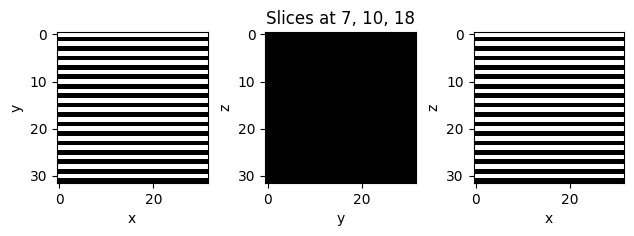

In [82]:
viewer(input_img[0,0].cpu().numpy(), x, y, z)

<Figure size 640x480 with 0 Axes>

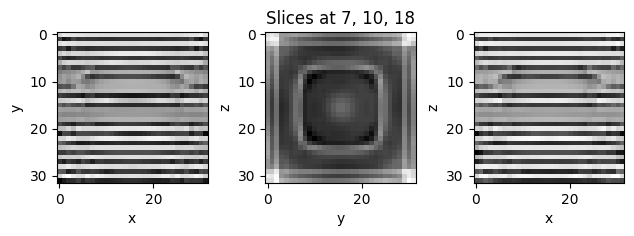

In [83]:
viewer(unet_model(input_img).cpu().detach().numpy()[0, 0], x, y, z)

In [11]:
unet_model.down.down_blocks[-1]

ConvolutionBlock(
  (gate1): Gate (112x0e+32x1e+16x2e -> 64x0e+32x1e+16x2e)
  (conv1): Convolution(
    (sc): Linear(32x0e+16x1e+8x2e -> 112x0e+32x1e+16x2e | 4224 weights)
    (tp): FullyConnectedTensorProduct(32x0e+16x1e+8x2e x 1x0e+1x1e+1x2e -> 112x0e+32x1e+16x2e | 10752 paths | 10752 weights)
  )
  (batchnorm1): BatchNorm (112x0e+32x1e+16x2e, eps=1e-05, momentum=0.1)
  (dropout1): Dropout (64x0e+32x1e+16x2e, p=0)
  (gate2): Gate (112x0e+32x1e+16x2e -> 64x0e+32x1e+16x2e)
  (conv2): Convolution(
    (sc): Linear(64x0e+32x1e+16x2e -> 112x0e+32x1e+16x2e | 8448 weights)
    (tp): FullyConnectedTensorProduct(64x0e+32x1e+16x2e x 1x0e+1x1e+1x2e -> 112x0e+32x1e+16x2e | 21504 paths | 21504 weights)
  )
  (batchnorm2): BatchNorm (112x0e+32x1e+16x2e, eps=1e-05, momentum=0.1)
  (dropout2): Dropout (64x0e+32x1e+16x2e, p=0)
)

In [12]:
unet_model.up.upsample_ops

ModuleList(
  (0-2): 3 x Upsample(scale_factor=(2.0, 2.0, 2.0), mode='trilinear')
)

In [13]:
def pad_size(image_shape,odd):

    pooling_factor = np.ones(3,dtype='int')
    for pool in unet_model.down.down_pool:
        pooling_factor *= np.array(pool.kernel_size)

    pad = [] 
    for f,s in zip(pooling_factor,image_shape):
        p = 0  #padding for current dimension
        if odd:
            t = (s - 1) % f
        else:
            t = s % f

        if t != 0:
            p = f - t
        pad.append(p)
    
    return pad

for x in dataloader:
    pass
print(x.shape)
pad = pad_size(x.shape[-3:],unet_model.odd_resize)
x = torch.nn.functional.pad(x, (pad[-1], 0, pad[-2], 0, pad[-3], 0))

down_output = unet_model.down(x)

torch.Size([1, 1, 32, 32, 32])


In [14]:
pad
# for a 3-layer model running on a 20x20x20 input
# (where all layers halve the data size along each dimension),
# this thing pads up the input to 24x24x24.
# so what if we do 32x32x32 instead

[0, 0, 0]

In [15]:
x.shape

torch.Size([1, 1, 32, 32, 32])

In [16]:
down_output.shape

torch.Size([1, 240, 4, 4, 4])

In [17]:
x = unet_model.up(down_output)
x = unet_model.out(x.transpose(1, 4)).transpose(1, 4)
if unet_model.bias is not None:
    bias = unet_model.bias.reshape(-1, 1, 1, 1)
    x = torch.cat([x[:, :unet_model.n_classes_scalar,...] + bias, x[:, unet_model.n_classes_scalar:,...]], dim=1)

x = x[..., pad[0]:, pad[1]:, pad[2]:]

In [18]:
x.shape

torch.Size([1, 1, 32, 32, 32])